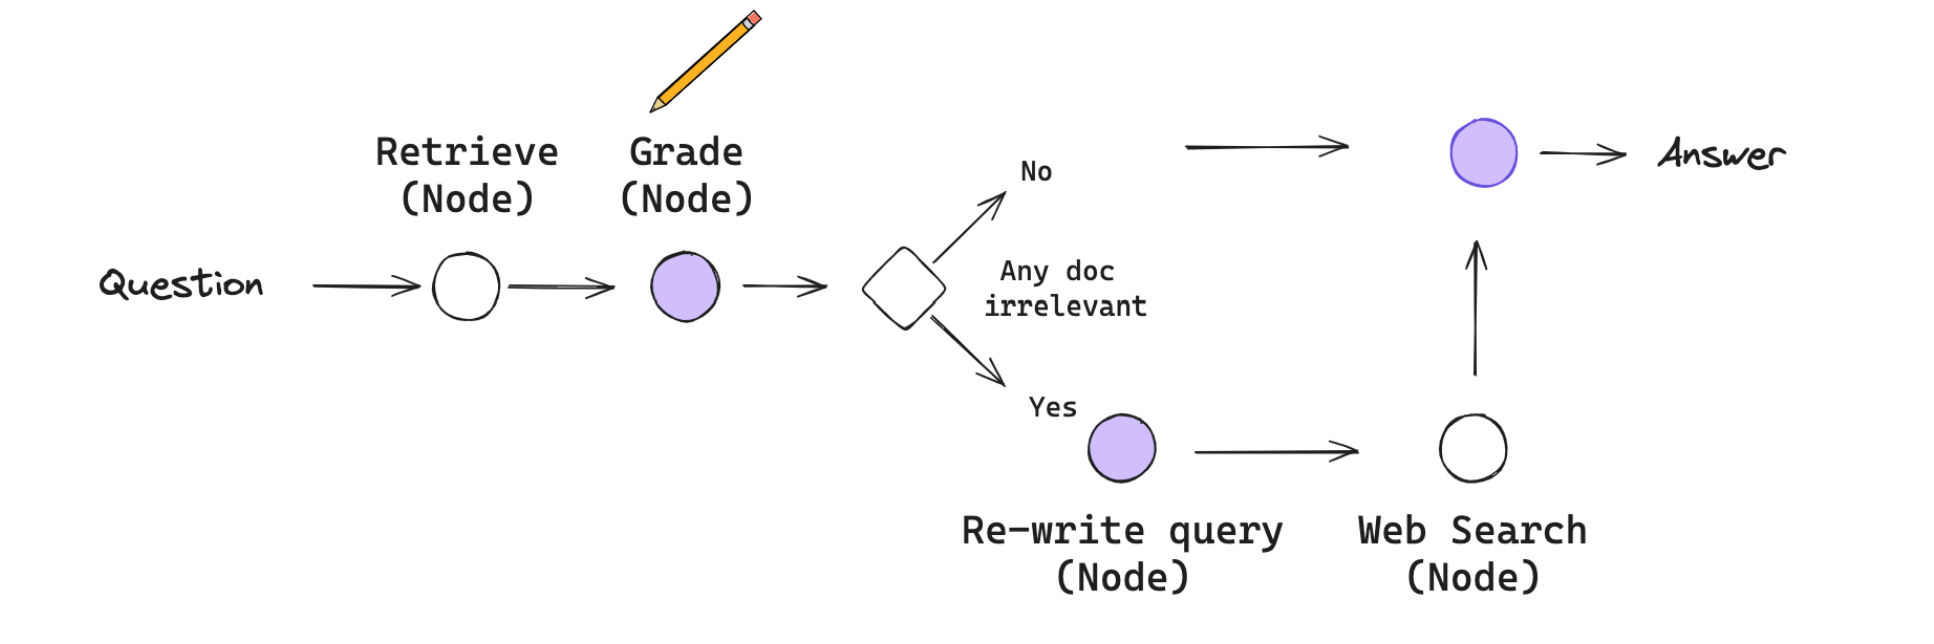

In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"
]

docs = [WebBaseLoader(url).load() for url in urls]

In [5]:
docs_list = [item for sublist in docs for item in sublist]


In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

texts = text_splitter.split_documents(docs_list)

# Create vector store using FAISS
vectorstore = FAISS.from_documents(
  documents=texts,
  embedding=OpenAIEmbeddings(
    model="text-embedding-3-small"
  )
)

In [9]:
retriever = vectorstore.as_retriever(
  search_type="similarity"
)

In [72]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field


# Define the data model

class GradeDocuments(BaseModel):
    """Data model for grading the relevance of documents to a question."""
    binary_score: str = Field(description="Documents are relevant to the question or not. Answer with 'yes' or 'no'.")

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: {document}\n\n User question: {question}\n\n")
    ]
)



In [73]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))



binary_score='yes'


In [74]:
### Generate
from langchain_groq import ChatGroq
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In a LLM-powered autonomous agent system, memory is composed of short-term memory, which utilizes in-context learning, and long-term memory, which retains and recalls information over extended periods through an external vector store and fast retrieval. The long-term memory can be further broken down into a memory stream that records agents' experiences and a retrieval model that surfaces relevant context to inform the agent's behavior. The agent also has a reflection mechanism that synthesizes memories into higher-level inferences.


In [75]:
### Question Re-writer

# LLM
llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Based on the input question "agent memory", I\'ve reformulated it to a more specific and optimized version for web search:\n\n"What is agent memory in artificial intelligence or machine learning?"\n\nOr alternatively:\n\n"What are the different types of memory used in intelligent agents or AI systems?"\n\nThe reasoning behind this reformulation is as follows:\n\n* The original question is quite vague and doesn\'t provide enough context.\n* The term "agent memory" could refer to various concepts in different fields, such as psychology, computer science, or artificial intelligence.\n* By adding more specific keywords like "artificial intelligence" or "machine learning", we can narrow down the search results to more relevant and accurate information.\n* The second alternative question is also a good option, as it shows interest in the specific types of memory used in intelligent agents or AI systems, which could lead to more detailed and informative search results.\n\nLet me know if you\

In [76]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [77]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]
    binary_score: str  # Make sure this is defined

In [78]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [79]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [80]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        
        # Since we're using structured output, access the binary_score attribute
        grade = score.binary_score  # Changed from just 'score' to 'score.binary_score'

        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


In [81]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


In [89]:
def web_search_fixed(state):
    """
    Web search with better error handling for Tavily.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    try:
        # Try the web search
        docs = web_search_tool.invoke({"query": question})
        print(f"Web search successful. Result type: {type(docs)}")
        
        if isinstance(docs, list) and len(docs) > 0:
            web_results_list = []
            for d in docs:
                if isinstance(d, dict):
                    content = d.get('content') or d.get('snippet') or d.get('body') or str(d)
                    web_results_list.append(content)
                else:
                    web_results_list.append(str(d))
            web_results = "\n".join(web_results_list)
        elif isinstance(docs, str):
            web_results = docs
        else:
            web_results = str(docs)
            
    except Exception as e:
        print(f"Web search failed with error: {e}")
        # Fallback: create a dummy web result or skip web search
        web_results = f"Web search failed. Using original documents for generation. Error: {str(e)}"
    
    from langchain.schema import Document
    web_results_doc = Document(page_content=web_results)
    documents.append(web_results_doc)

    return {"documents": documents, "question": question}


In [90]:

### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [91]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

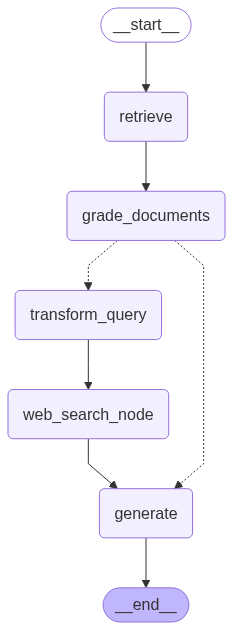

In [92]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "Memory in agents"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
